# 导入必须的模块

In [1]:
# 导入模块
print("导入模块")
!pip install pycocotools
# !pip uninstall torchvision
# !pip install -U torchvision==0.8.2
import os
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler
import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model
from matplotlib import pyplot as plt
from PIL import Image
from train import get_args_parser
import time
print("模块导入成功！")

导入模块
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
模块导入成功！


/opt/conda/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


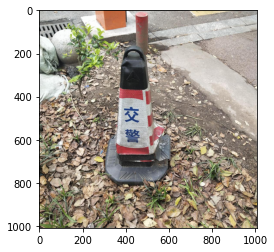

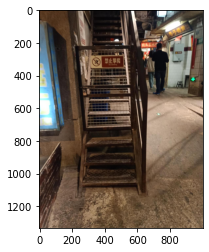

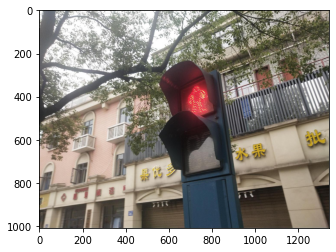

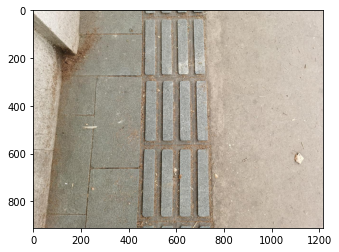

In [2]:
# 定义展示图片函数并展示几张图片
def show_image(image_path):
    plt.figure()
    image = Image.open(image_path)
    plt.imshow(image)
show_image('MyDatasets/test/LZ122.jpg')
show_image('MyDatasets/test/LT49.jpg')
show_image('MyDatasets/test/hld011.jpg')
show_image('MyDatasets/test/75.jpg')

#  参数配置

In [3]:
print("设置基本参数")
class config:
    lr = 1e-4 # 学习率
    lr_backbone = 1e-5 # backbone的学习率
    lr_drop = 50 # 学习率衰减
    batch_size = 1 # 批次大小
    weight_decay = 1e-4 # 权重衰减
    epochs = 1 # 训练回合数
    one_epoch_steps = 2 # 一个epoch中的迭代次数
    # dataset parameters
    num_classes = 5 # 类别数

    dataset_file = "custom" # 使用自定义的数据库函数，不需要更改

    coco_path = r"MyDatasets" # 自定义数据集路径的路径

    # device = 'cuda' if torch.cuda.is_available() else "cpu" # device to use for training / testing

    device = "cpu"

    seed = 42 # 随机种子

    resume = "detr-r50_no-class-head.pth" # 'resume from checkpoint'

    num_workers = 1 # 读取数据的进程数

    output_dir = "outputs" # 保存模型的路径
    
print("设置完成")

设置基本参数
设置完成


# 训练前的准备工作

In [4]:
# 获取配置参数
print("加载参数")
args = get_args_parser(config()).parse_args([])
if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)

# 初始化分布式模型参数配置
utils.init_distributed_mode(args)

# 打印参数配置信息
print(args)

# 设定是cpu还是gpu环境
device = torch.device(args.device)

# 固定随机种子以便于复现
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
print("加载完成")

加载参数
Not using distributed mode
Namespace(aux_loss=True, backbone='resnet50', batch_size=1, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='MyDatasets', dataset_file='custom', dec_layers=1, device='cpu', dice_loss_coef=1, dilation=False, dim_feedforward=64, dist_url='env://', distributed=False, dropout=0.1, enc_layers=1, eos_coef=0.1, epochs=1, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=4, lr=0.0001, lr_backbone=1e-05, lr_drop=50, mask_loss_coef=1, masks=False, nheads=4, num_classes=5, num_queries=100, num_workers=1, one_epoch_steps=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume=False, seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=3)
加载完成


In [7]:
print("建立模型")
!cp /home/admin/jupyter/resnet50-19c8e357.pth /home/admin/.cache/torch/hub/checkpoints/
# 建立模型
model, criterion, postprocessors = build_model(args) 
model.to(device)

# 将模型分为多卡分布式模型和单卡训练模型，根据需求使用模型
model_without_ddp = model
if args.distributed:
    # 使用分布式模型
    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
    model_without_ddp = model.module
# 打印模型结构
net_struct = open("nets.txt","r").read()
print(net_struct)
print("模型建立完成")

建立模型
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]           9,408
 FrozenBatchNorm2d-2         [-1, 64, 400, 400]             128
              ReLU-3         [-1, 64, 400, 400]               0
         MaxPool2d-4         [-1, 64, 200, 200]               0
            Conv2d-5         [-1, 64, 200, 200]           4,096
 FrozenBatchNorm2d-6         [-1, 64, 200, 200]             128
              ReLU-7         [-1, 64, 200, 200]               0
            Conv2d-8         [-1, 64, 200, 200]          36,864
 FrozenBatchNorm2d-9         [-1, 64, 200, 200]             128
             ReLU-10         [-1, 64, 200, 200]               0
           Conv2d-11        [-1, 256, 200, 200]          16,384
FrozenBatchNorm2d-12        [-1, 256, 200, 200]             512
           Conv2d-13        [-1, 256, 200, 200]          16,384
FrozenBatchNorm2d-14        [-1, 2

In [8]:
print("设置训练参数配置")
# 冻结骨干网络
for n, p in model.named_parameters():
    if ("backbone" in n or "transformer" in n) and p.requires_grad:
        p.requires_grad = False
# 获取并打印模型参数数量
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('训练参数量:', n_parameters)

# 给backbone和主网络分别配置优化器
param_dicts = [
    {"params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad]},
    {
        "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
        "lr": args.lr_backbone,
    },
]
# 定义优化器
optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                              weight_decay=args.weight_decay)

# 设置学习率衰减策略
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)
print("配置完成")

设置训练参数配置
训练参数量: 8686
配置完成


In [9]:
print("设置数据参数")
# 读取训练集，验证集
dataset_train = build_dataset(image_set='train', args=args)
dataset_val = build_dataset(image_set='val', args=args)

# 根据是否采用分布式训练分配每一batch的数据
if args.distributed:
    sampler_train = DistributedSampler(dataset_train)
    sampler_val = DistributedSampler(dataset_val, shuffle=False)
else:
    # 随机取样
    sampler_train = torch.utils.data.RandomSampler(dataset_train)
    sampler_val = torch.utils.data.SequentialSampler(dataset_val)
# 设置取样策略
batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, args.batch_size, drop_last=True)

# 设置训练dataloader
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                               collate_fn=utils.collate_fn, num_workers=args.num_workers)
# 设置测试dataloader
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                             drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

if args.dataset_file == "coco_panoptic":
    # We also evaluate AP during panoptic training, on original coco DS
    coco_val = datasets.coco.build("val", args)
    base_ds = get_coco_api_from_dataset(coco_val)
else:
    # 对验证数据做单独处理，一般是不对验证集做数据增强
    base_ds = get_coco_api_from_dataset(dataset_val)

# 如果冻结参数，则读取预训练权重进行训练
if args.frozen_weights is not None:
    checkpoint = torch.load(args.frozen_weights, map_location='cpu')
    model_without_ddp.detr.load_state_dict(checkpoint['model'])

# 保存路径
output_dir = Path(args.output_dir)
print("设置完成")

设置数据参数
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
设置完成


In [10]:
print("读取预训练配置")
if args.resume:
    # 读取预训练模型配置，包括权重，学习率，epoch等参数，也可以读取之前自己未训练完成的模型继续训练
    if args.resume.startswith('https'):
        checkpoint = torch.hub.load_state_dict_from_url(
            args.resume, map_location='cpu', check_hash=True)
    else:
        checkpoint = torch.load(args.resume, map_location='cpu')
    # 读取模型权重
    model_without_ddp.load_state_dict(checkpoint['model'], strict=False)
    # 读取训练配置参数
    if not args.eval and 'optimizer' in checkpoint and 'lr_scheduler' in checkpoint and 'epoch' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        args.start_epoch = checkpoint['epoch'] + 1
print("读取完成")

读取预训练配置
读取完成


# 开始训练

In [13]:
print("开始训练")
# 记录训练时间
start_time = time.time()
for epoch in range(args.start_epoch, args.epochs):
    print('\n' + '-' * 10 + 'Train one epoch.' + '-' * 10)
    print('Epoch:'+ str(epoch+1) + '/' + str(args.epochs))
    # 训练一个epoch
    train_stats = train_one_epoch(
        model, criterion, data_loader_train, optimizer, device, epoch,
        args.clip_max_norm,args.one_epoch_steps)
    # 学习率衰减
    lr_scheduler.step()
    # 保存模型
    if args.output_dir:
        checkpoint_paths = [output_dir / 'checkpoint.pth']
        # extra checkpoint before LR drop and every 100 epochs
        if (epoch + 1) % args.lr_drop == 0 or (epoch + 1) % 100 == 0:
            checkpoint_paths.append(output_dir / f'checkpoint{epoch:04}.pth')
        for checkpoint_path in checkpoint_paths:
            utils.save_on_master({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'args': args,
            }, checkpoint_path)
    
# 显示训练总耗时
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))
print("训练完成")

开始训练

----------Train one epoch.----------
Epoch:1/1
step:1/2 || Total Loss: 6.8409 || 88.0018s/step
step:2/2 || Total Loss: 5.4169 || 57.3856s/step
Training time 0:02:25
训练完成
